# Design simple NN with Keras

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#traintestsplit
from sklearn.model_selection import train_test_split

# Force TensorFlow to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [31]:
print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

Training device: GPU


## Data

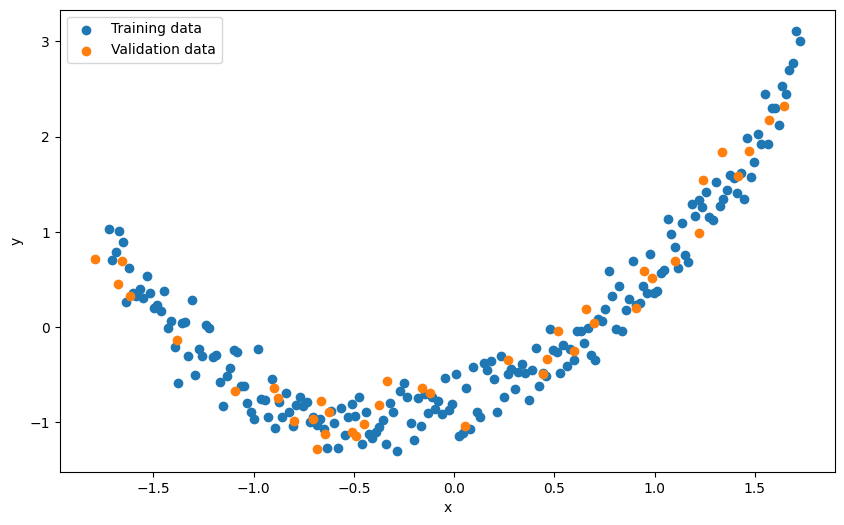

In [32]:
# Generate synthetic data
np.random.seed(0)
x_values = np.linspace(-5, 5, 200).astype(np.float32)
y_values = x_values**2 + 2*x_values + 1 + np.random.normal(0, 2, size=200).astype(np.float32)


# Randomly split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_values, y_values, test_size=0.2, random_state=42)


# Normalize the data
x_mean, x_std = np.mean(x_values), np.std(x_values)
y_mean, y_std = np.mean(y_values), np.std(y_values)
x_mean_val, x_std_val = np.mean(x_val), np.std(x_val)
y_mean_val, y_std_val = np.mean(y_val), np.std(y_val)

x_norm = (x_values - x_mean) / x_std
y_norm = (y_values - y_mean) / y_std
x_val_norm = (x_val - x_mean_val) / x_std_val
y_val_norm = (y_val - y_mean_val) / y_std_val

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(x_norm, y_norm, label='Training data')
plt.scatter(x_val_norm, y_val_norm, label='Validation data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Model

In [33]:
# Define the model
class FunctionApproximator(keras.Model):
    def __init__(self):
        super(FunctionApproximator, self).__init__()
        self.dense1 = keras.layers.Dense(16, activation='relu', input_shape=(1,))
        self.dense2 = keras.layers.Dense(16, activation='relu')
        self.dense3 = keras.layers.Dense(1)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Instantiate the model, loss function, and optimizer
model = FunctionApproximator()
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Custom training loop
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(x, y):
    predictions = model(x)
    loss = loss_fn(y, predictions)
    return loss

### Training steps


Epoch 10, Loss: 0.05725332349538803, Val Loss: 0.04413636773824692
Epoch 20, Loss: 0.06289955973625183, Val Loss: 0.03757842630147934
Epoch 30, Loss: 0.06327956914901733, Val Loss: 0.032280080020427704
Epoch 40, Loss: 0.04659079387784004, Val Loss: 0.03961380943655968
Epoch 50, Loss: 0.018103908747434616, Val Loss: 0.04298354312777519
Epoch 60, Loss: 0.028921158984303474, Val Loss: 0.03607555478811264
Epoch 70, Loss: 0.0658697783946991, Val Loss: 0.035339660942554474
Epoch 80, Loss: 0.01610076241195202, Val Loss: 0.03785908222198486
Epoch 90, Loss: 0.04000275582075119, Val Loss: 0.035465825349092484
Epoch 100, Loss: 0.017636049538850784, Val Loss: 0.05084242671728134
Epoch 110, Loss: 0.021128974854946136, Val Loss: 0.04037843272089958
Epoch 120, Loss: 0.06694572418928146, Val Loss: 0.03824004903435707
Epoch 130, Loss: 0.06455312669277191, Val Loss: 0.03540480509400368
Epoch 140, Loss: 0.04453359916806221, Val Loss: 0.039911042898893356
Epoch 150, Loss: 0.07678544521331787, Val Loss: 0.

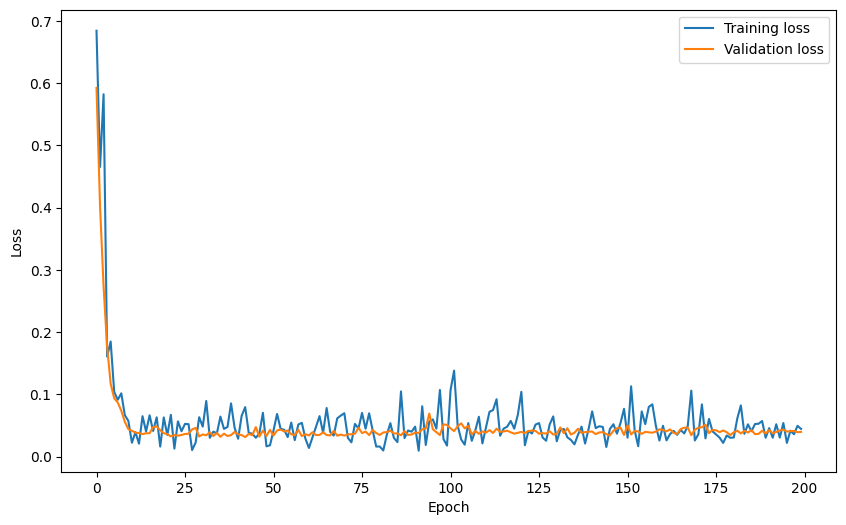

In [34]:
# Training
epochs = 200
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_norm.reshape(-1, 1), y_norm.reshape(-1, 1))).shuffle(200).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_norm.reshape(-1, 1), y_val_norm.reshape(-1, 1))).batch(40)

train_losses = []
val_losses = []

for epoch in range(epochs):
    for x_batch, y_batch in train_dataset:
        train_loss = train_step(x_batch, y_batch)
    train_losses.append(train_loss)
    
    for x_val_batch, y_val_batch in val_dataset:
        val_loss = val_step(x_val_batch, y_val_batch)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {train_loss.numpy()}, Val Loss: {val_loss.numpy()}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

10/10 [==============================] - 0s 1ms/step


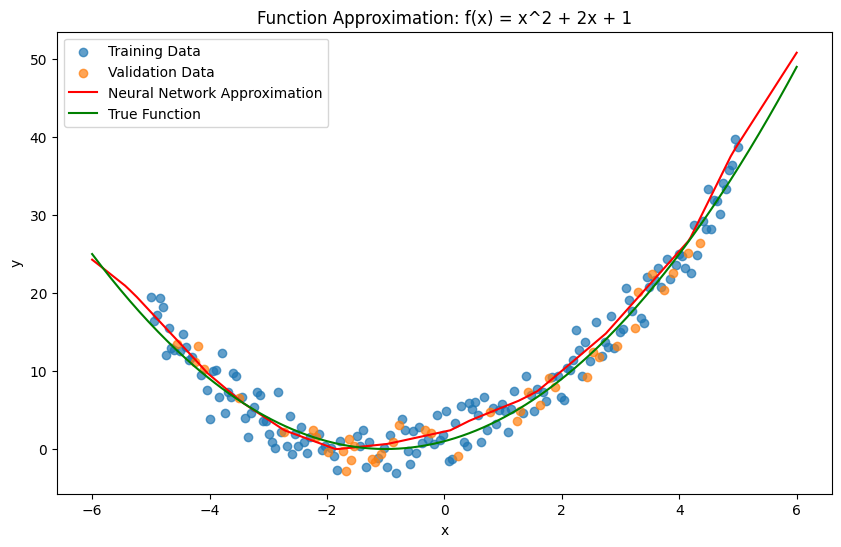

In [35]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, alpha=0.7, label='Training Data')
plt.scatter(x_val, y_val, alpha=0.7, label='Validation Data')
x_test = np.linspace(-6, 6, 300).astype(np.float32)  # Extend beyond training range to see extrapolation
x_test_norm = (x_test - x_mean) / x_std
predicted_y_norm = model.predict(x_test_norm.reshape(-1, 1))
predicted_y = predicted_y_norm * y_std + y_mean
plt.plot(x_test, predicted_y, color='red', label='Neural Network Approximation')
plt.plot(x_test, x_test**2 + 2*x_test + 1, color='green', label='True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Approximation: f(x) = x^2 + 2x + 1')
plt.legend()
plt.show()

In [36]:
# Make a prediction
new_x = 4.5
new_x_norm = (new_x - x_mean) / x_std
predicted_y_norm = model.predict(np.array([[new_x_norm]]))
predicted_y = predicted_y_norm * y_std + y_mean

print(f"Predicted y for x = {new_x}: {predicted_y[0][0]:.2f}")
print(f"True y for x = {new_x}: {new_x**2 + 2*new_x + 1:.2f}")

1/1 [==============================] - 0s 23ms/step
Predicted y for x = 4.5: 31.81
True y for x = 4.5: 30.25
